In [14]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

(768, 1024, 3)
<class 'numpy.uint8'>


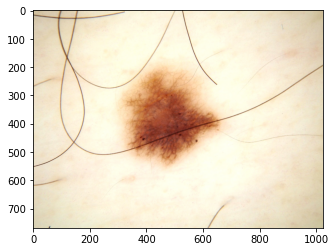

In [241]:
image_path = '29/ISIC_0010014.jpg'
image = cv2.imread(image_path)
print(image.shape)
print(type(image[0][0][0]))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [101]:
import PIL.Image
img = PIL.Image.open('29/ISIC_0010014.jpg')
exif_data = img._getexif()
print(exif_data)

None


In [10]:
import exifread
# Open image file for reading (binary mode)
f = open('29/ISIC_0010014.jpg', 'rb')

# Return Exif tags
tags = exifread.process_file(f)
tags

{}

In [108]:
# https://isic-archive.com/api/v1#!/image/image_find
# using api to retrieve data of the image
import requests
parameters = {'name': 'ISIC_0010014'}
image_data = requests.get("https://isic-archive.com/api/v1/image/", params = parameters)

In [109]:
image_data.json()

[{'_id': '558d60cdbae47801cf734513',
  'name': 'ISIC_0010014',
  'updated': '2015-10-02T15:33:45.274000+00:00'}]

In [110]:
data = requests.get("https://isic-archive.com/api/v1/image/"+str(image_data.json()[0]['_id']))
data.json()

{'_id': '558d60cdbae47801cf734513',
 '_modelType': 'image',
 'created': '2015-06-26T14:25:17.476000+00:00',
 'creator': {'_id': '54cb974fbae47819d8e4c727', 'name': 'User GQZH'},
 'dataset': {'_accessLevel': 0,
  '_id': '5a2ecc5d1165975c94594284',
  'description': 'Biopsy-confirmed melanocytic and non-melanocytic skin lesions.\nThis dataset includes over 500 melanomas. Many images have polarized and contact variants.',
  'license': 'CC-0',
  'name': 'MSK-2',
  'updated': '2015-10-21T20:33:29.916000+00:00'},
 'meta': {'acquisition': {'image_type': 'dermoscopic',
   'pixelsX': 1024,
   'pixelsY': 768},
  'clinical': {'age_approx': 50,
   'anatom_site_general': 'anterior torso',
   'benign_malignant': 'benign',
   'clin_size_long_diam_mm': 4.0,
   'diagnosis': 'nevus',
   'diagnosis_confirm_type': 'histopathology',
   'family_hx_mm': False,
   'melanocytic': True,
   'personal_hx_mm': False,
   'sex': 'male'}},
 'name': 'ISIC_0010014',
 'notes': {'reviewed': {'accepted': True,
   'time': '

In [111]:
data.json()['meta']['clinical']['diagnosis']

'nevus'

In [112]:
# Classes:
# Melanoma
# Melanocytic nevus
# Basal cell carcinoma
# Actinic keratosis / Bowen’s disease (intraepithelial carcinoma)
# Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis)
# Dermatofibroma
# Vascular lesion
# Squamous cell carcinoma

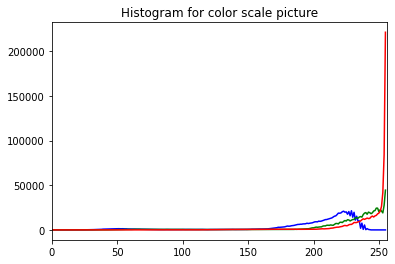

In [116]:
color = ('b','g','r')
for channel,col in enumerate(color):
    histr = cv2.calcHist([image],[channel],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.title('Histogram for color scale picture')
plt.show()

The maximum flow for 29/ISIC_0010014.jpg is 20212848


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


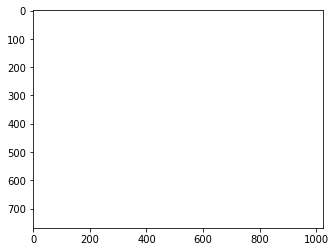

In [127]:
# -*- coding: utf-8 -*-
from numpy import *
import numpy
import maxflow
from PIL import Image
from matplotlib import pyplot as plt
from pylab import *
import cv2

#The function implements graph cut by partitioning a directed graph into two disjoint sets, foreground and background...
def graph(file, # input image
k, # kappa value --> similar pixels have weight close to kappa
s, # Sigma value --> determines how fast the values decay towards zero with increasing dissimilarity.
fore, # foreground area ---> should be input by the user manually.
back): # background area ---> should be input by the user manually.
    I = (Image.open(file).convert('L')) # read image
    If = I.crop(fore) # take a part of the foreground
    Ib = I.crop(back) # take a part of the background
    I,If,Ib = array(I),array(If),array(Ib) # convert all the images to arrays to calculation
    Ifmean,Ibmean = mean(cv2.calcHist([If],[0],None,[256],[0,256])),mean(cv2.calcHist([Ib],[0],None,[256],[0,256])) #Taking the mean of the histogram
    F,B =  ones(shape = I.shape),ones(shape = I.shape) #initalizing the foreground/background probability vector
    Im = I.reshape(-1,1) #Coverting the image array to a vector for ease.
    m,n = I.shape[0],I.shape[1]# copy the size
    g,pic = maxflow.Graph[int](m,n),maxflow.Graph[int]() # define the graph
    structure = np.array([[inf, 0, 0],
                          [inf, 0, 0],
                          [inf, 0, 0]
                         ]) # initializing the structure....
    source,sink,J = m*n,m*n+1,I # Defining the Source and Sink (terminal)nodes.
    nodes,nodeids = g.add_nodes(m*n),pic.add_grid_nodes(J.shape) # Adding non-nodes
    pic.add_grid_edges(nodeids,0),pic.add_grid_tedges(nodeids, J, 255-J)
    gr = pic.maxflow()
    IOut = pic.get_grid_segments(nodeids)
    for i in range(I.shape[0]): # Defining the Probability function....
        for j in range(I.shape[1]):
            F[i,j] = -log(abs(I[i,j] - Ifmean)/(abs(I[i,j] - Ifmean)+abs(I[i,j] - Ibmean))) # Probability of a pixel being foreground
            B[i,j] = -log(abs(I[i,j] - Ibmean)/(abs(I[i,j] - Ibmean)+abs(I[i,j] - Ifmean))) # Probability of a pixel being background
    F,B = F.reshape(-1,1),B.reshape(-1,1) # convertingb  to column vector for ease
    for i in range(Im.shape[0]):
        Im[i] = Im[i] / linalg.norm(Im[i]) # normalizing the input image vector 
    w = structure # defining the weight       
    for i in range(m*n):#checking the 4-neighborhood pixels
        ws=(F[i]/(F[i]+B[i])) # source weight
        wt=(B[i]/(F[i]+B[i])) # sink weight
        g.add_tedge(i,ws[0],wt) # edges between pixels and terminal
        if i%n != 0: # for left pixels
            w = k*exp(-(abs(Im[i]-Im[i-1])**2)/s) # the cost function for two pixels
            g.add_edge(i,i-1,w[0],k-w[0]) # edges between two pixels
            '''Explaination of the likelihood function: * used Bayes’ theorem for conditional probabilities
            * The function is constructed by multiplying the individual conditional probabilities of a pixel being either 
            foreground or background in order to get the total probability. Then the class with highest probability is selected.
            * for a pixel i in the image:
                               * weight from sink to i:
                               probabilty of i being background/sum of probabilities
                               * weight from source to i:
                               probabilty of i being foreground/sum of probabilities
                               * weight from i to a 4-neighbourhood pixel:
                                K * e−|Ii−Ij |2 / s
                                 where k and s are parameters that determine hwo close the neighboring pixels are how fast the values
                                 decay towards zero with increasing dissimilarity
            '''
        if (i+1)%n != 0: # for right pixels
            w = k*exp(-(abs(Im[i]-Im[i+1])**2)/s)
            g.add_edge(i,i+1,w[0],k-w[0]) # edges between two pixels
        if i//n != 0: # for top pixels
            w = k*exp(-(abs(Im[i]-Im[i-n])**2)/s)
            g.add_edge(i,i-n,w[0],k-w[0]) # edges between two pixels
        if i//n != m-1: # for bottom pixels
            w = k*exp(-(abs(Im[i]-Im[i+n])**2)/s)
            g.add_edge(i,i+n,w[0],k-w[0]) # edges between two pixels
    I = array(Image.open(file)) # calling the input image again to ensure proper pixel intensities....
    print ("The maximum flow for %s is %d"%(file,gr)) # find and print the maxflow
    Iout = ones(shape = nodes.shape)
    for i in range(len(nodes)):
        Iout[i] = g.get_segment(nodes[i]) # calssifying each pixel as either forground or background
    out = 255*ones((I.shape[0],I.shape[1],3)) # initialization for 3d input
    for i in range(I.shape[0]):
        for j in range(I.shape[1]): # converting the True/False to Pixel intensity
            if IOut[i,j]==False:
                if len(I.shape) == 2:
                    out[i,j,0],out[i,j,1],out[i,j,2] = I[i,j],I[i,j],I[i,j] # foreground for 2d image
                if len(I.shape) == 3:
                    out[i,j,0],out[i,j,1],out[i,j,2] = I[i,j,0],I[i,j,1],I[i,j,2] # foreground for 3d image
            else:
                out[i,j,0],out[i,j,1],out[i,j,2] = 1,255,255 # red background 
    figure()
    plt.imshow(out,vmin=0,vmax=255) # plot the output image
    plt.show()

graph('29/ISIC_0010014.jpg',2,100,(225,142,279,185),(7,120,61,163)) #calling the maxflow funtion for input1

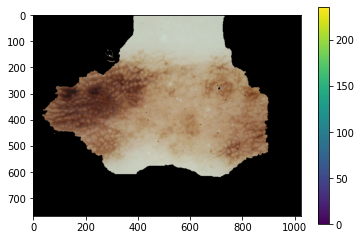

CPU times: user 44.5 s, sys: 357 ms, total: 44.9 s
Wall time: 45.3 s


In [215]:
%%time
# Python program to illustrate  
# foreground extraction using 
# GrabCut algorithm 
   
# organize imports 
import numpy as np 
import cv2 
from matplotlib import pyplot as plt 
   
# path to input image specified and  
# image is loaded with imread command 
image = cv2.imread('29/ISIC_0010022.jpg') 
   
# create a simple mask image similar 
# to the loaded image, with the  
# shape and return type 
mask = np.zeros(image.shape[:2], np.uint8) 
   
# specify the background and foreground model 
# using numpy the array is constructed of 1 row 
# and 65 columns, and all array elements are 0 
# Data type for the array is np.float64 (default) 
backgroundModel = np.zeros((1, 65), np.float64) 
foregroundModel = np.zeros((1, 65), np.float64) 
   
# define the Region of Interest (ROI) 
# as the coordinates of the rectangle 
# where the values are entered as 
# (startingPoint_x, startingPoint_y, width, height) 
# these coordinates are according to the input image 
# it may vary for different images 
rectangle = (0, 0, 900, 700) 
   
# apply the grabcut algorithm with appropriate 
# values as parameters, number of iterations = 3  
# cv2.GC_INIT_WITH_RECT is used because 
# of the rectangle mode is used  
cv2.grabCut(image, mask, rectangle,   
            backgroundModel, foregroundModel, 
            10, cv2.GC_INIT_WITH_RECT) 
   
# In the new mask image, pixels will  
# be marked with four flags  
# four flags denote the background / foreground  
# mask is changed, all the 0 and 2 pixels  
# are converted to the background 
# mask is changed, all the 1 and 3 pixels 
# are now the part of the foreground 
# the return type is also mentioned, 
# this gives us the final mask 
mask2 = np.where((mask == 2)|(mask == 0), 0, 1).astype('uint8') 
   
# The final mask is multiplied with  
# the input image to give the segmented image. 
image = image * mask2[:, :, np.newaxis] 
   
# output segmented image with colorbar 
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) 
plt.colorbar() 
plt.show() 

In [21]:
import skimage
import skimage.color
import skimage.filters

In [32]:
blur = skimage.color.rgb2gray(image)
blur = skimage.filters.gaussian(blur, sigma=2)
val = skimage.filters.threshold_otsu(blur)
val

0.6512535328471004

In [23]:
mask = blur<val

In [24]:
sel = np.zeros_like(image)
sel[mask] = image[mask]

mask

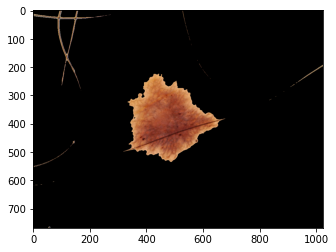

In [59]:
plt.imshow(cv2.cvtColor(sel, cv2.COLOR_BGR2RGB))

In [29]:
# Otsu's thresholding after Gaussian filtering
img = cv2.imread(image_path,0)
blur = cv2.GaussianBlur(img,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

In [31]:
ret3

179.0

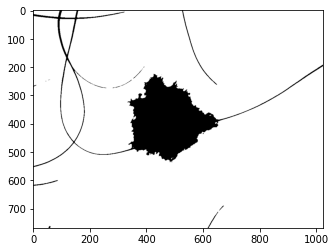

In [35]:
plt.imshow(cv2.cvtColor(th3, cv2.COLOR_BGR2RGB))

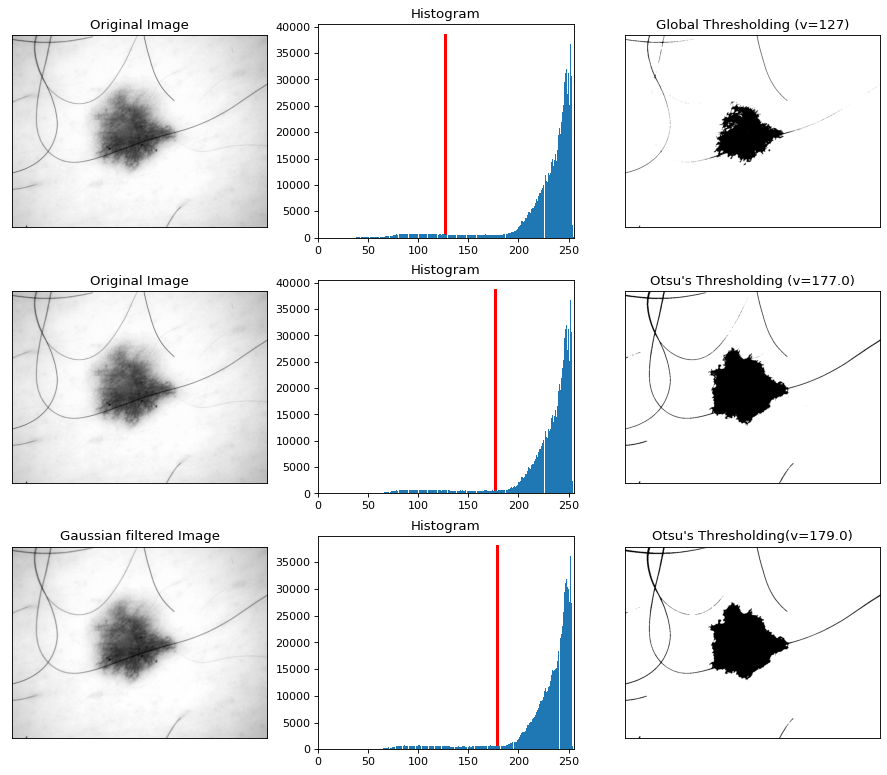

In [103]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(14, 12), dpi=80, facecolor='w', edgecolor='k')
img = cv2.imread(image_path,0)

# global thresholding
ret1,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

# Otsu's thresholding
ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(img,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]
titles = ['Original Image','Histogram','Global Thresholding (v=127)',
          'Original Image','Histogram',"Otsu's Thresholding (v={})".format(ret2),
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding(v={})".format(ret3)]
threshold = [127, ret2, ret3]
for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.xlim([0, 255])
    xmin,xmax,ymin,ymax = plt.axis()
    plt.scatter([threshold[i]]*int(ymax),range(0, int(ymax)),color ='red', s=1)
    plt.title(titles[i*3+1])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

In [104]:
from numpy import *
from sklearn import mixture
import maxflow

# use RGB color
def init_graph(img_array, k, sigma, F_Pixels, B_Pixels):
    # k = similar pixels have weight close to kappa
    # Sigma value --> determines how fast the values decay towards zero with increasing dissimilarity.
    I, F_Pixels, B_Pixels = array(img_array), array(F_Pixels), array(B_Pixels) # convert images to numpy arrays
    x_train = concatenate([F_Pixels, B_Pixels]) # stack input to training data, foreground and background
    clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
    clf.fit(x_train) # fit GMM model

    Im = I.reshape(-1,3) #converting the image array to a vector for ease
    m,n = I.shape[0],I.shape[1]# copy the size

    g = maxflow.Graph[int](m, n)
    nodes = g.add_nodes(m*n)
    # compute likelihoods
    for i in range(0, n*m):#checking the 4-neighborhood pixels
        weights = clf.predict_proba([Im[i]])
        source_weight = weights[0][0]
        sink_weight = weights[0][1]
        g.add_tedge(i, source_weight, sink_weight)

        # four neighboring pixels
        if i%n != 0: # for left pixels
            w = k*exp(-(linalg.norm(Im[i]-Im[i-1]))/sigma) # the cost function for two pixels is the frobenous norm between pixels
            g.add_edge(i, i-1, w, k-w)

        if (i+1)%n != 0: # for right pixels
            w = k*exp(-(linalg.norm(Im[i]-Im[i+1]))/sigma)
            g.add_edge(i, i+1, w, k-w)

        if i//n != 0: # for top pixels
            w = k*exp(-(linalg.norm(Im[i]-Im[i-n]))/sigma)
            g.add_edge(i, i-n, w, k-w)

        if i//n != m-1: # for bottom pixels
            w = k*exp(-(linalg.norm(Im[i]-Im[i+n]))/sigma)
            g.add_edge(i, i+n, w, k-w)

    # compute max flow
    g.maxflow()
    Iout = ones(shape = nodes.shape)
    for i in range(len(nodes)):
        Iout[i] = g.get_segment(nodes[i])

    return Iout

In [177]:
init_graph(image, 2,[100,50],(225,142,279,185),(7,120,61,163))

ValueError: Expected 2D array, got 1D array instead:
array=[225. 142. 279. 185.   7. 120.  61. 163.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

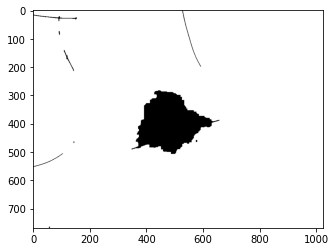

In [254]:
import numpy as np
import scipy
#from scipy.misc import imread
import imageio
import maxflow

img = cv2.imread(image_path,0)

# Create the graph.
g = maxflow.Graph[int]()
# Add the nodes. nodeids has the identifiers of the nodes in the grid.
nodeids = g.add_grid_nodes(img.shape)
# Add non-terminal edges with the same capacity.
g.add_grid_edges(nodeids, 50)
# Add the terminal edges. The image pixels are the capacities
# of the edges from the source node. The inverted image pixels
# are the capacities of the edges to the sink node.
g.add_grid_tedges(nodeids, img, 255-img)

# Find the maximum flow.
g.maxflow()
# Get the segments of the nodes in the grid.
sgm = g.get_grid_segments(nodeids)

# The labels should be 1 where sgm is False and 0 otherwise.
img2 = np.int_(np.logical_not(sgm))
# Show the result.
from matplotlib import pyplot as ppl
img2 = np.array(img2)
for i in range(img2.shape[0]):
    for j in range(img2.shape[1]):
        if img2[i][j]==1:
            img2[i][j]=255
img2 = img2.astype(np.uint8)
ppl.imshow(cv2.cvtColor(img2, cv2.COLOR_GRAY2RGB))
ppl.show()

In [163]:
img2.shape

(768, 1024)

In [158]:
img2 = np.array(img2)

In [159]:
np.unique(img2)

array([  0, 255])

In [140]:
x = img2==1

In [141]:
img2[x]=255

In [171]:
type(img2[0][0])

numpy.int64

In [169]:
ppl.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY))

error: OpenCV(4.4.0) ../modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = (cv::impl::<unnamed>::SizePolicy)2; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


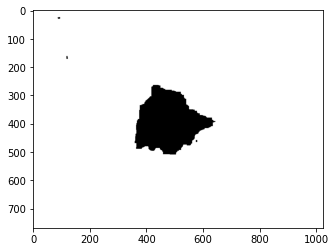

In [253]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

from maxflow.fastmin import aexpansion_grid

# Loading image
I = imageio.imread(image_path)
I = I[:,:,1]/I.max()

# Generates 16 gray levels for nearsest prototype labeling
L = 2
levs = np.arange(0.5/L, 1, 1/L)

# Calculate data cost as the absolute difference between the label prototype and the pixel value
D = np.abs(I.reshape(I.shape+(1,)) - levs.reshape((1,1,-1)))

# Calculate neighbourhood cost as absolute difference between prototypes 
alpha = 1
V = alpha * np.abs( levs.reshape((-1,1)) - levs.reshape((1,-1)))

# Graph_Cut alpha expansion method
labels = aexpansion_grid(D,V)


# plotting
fg = plt.figure("Regularised labeling")
labels = labels.astype(np.uint8)
OldMin = 0
OldMax = max(np.unique(labels))
NewMin = 0
NewMax = 255
for i in range(labels.shape[0]):
    for j in range(labels.shape[1]):
        OldValue = labels[i][j]

        OldRange = (OldMax - OldMin)  
        NewRange = (NewMax - NewMin)  
        labels[i][j] = int((((OldValue - OldMin) * NewRange) / OldRange) + NewMin)



labels = cv2.cvtColor(labels, cv2.COLOR_GRAY2RGB)
labels = labels.astype(np.uint8)
plt.imshow(cv2.cvtColor(labels, cv2.COLOR_RGB2BGR))

In [206]:
np.unique(labels)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [197]:
np.unique(Id)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=uint8)

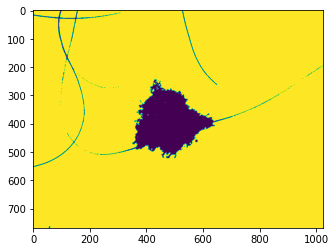

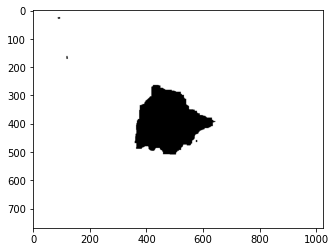

In [303]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

from maxflow.fastmin import abswap_grid

# Loading image
I = imageio.imread(image_path)
I = I[:,:,1]/I.max()

# Generates 2 gray levels for nearsest prototype labeling
L = 2
levs = np.arange(0.5/L, 1, 1/L)

# Calculate data cost as the absolute difference between the label prototype and the pixel value
D = np.abs(I.reshape(I.shape+(1,)) - levs.reshape((1,1,-1)))

# Generate nearest prototype labeling
Id = np.argmin(D,2)

fg = plt.figure("Direct labeling")
ax1 = fg.add_subplot(1,1,1)
Id = Id.astype(uint8)
ax1.imshow(Id)

# Calculate neighbourhood cost as absolute difference between prototypes 
alpha = 1
V = alpha * np.abs( levs.reshape((-1,1)) - levs.reshape((1,-1)))

# Mimimise data + neighbourhood cost
labels = abswap_grid(D,V)

fg = plt.figure("Regularised labeling")
ax1 = fg.add_subplot(1,1,1)
labels = labels.astype(np.uint8)
OldMin = 0
OldMax = max(np.unique(labels))
NewMin = 0
NewMax = 255
for i in range(labels.shape[0]):
    for j in range(labels.shape[1]):
        OldValue = labels[i][j]

        OldRange = (OldMax - OldMin)  
        NewRange = (NewMax - NewMin)  
        labels[i][j] = int((((OldValue - OldMin) * NewRange) / OldRange) + NewMin)



labels = cv2.cvtColor(labels, cv2.COLOR_GRAY2RGB)
labels = labels.astype(np.uint8)
ax1.imshow(labels)

(768, 1024, 3)
<class 'numpy.uint8'>


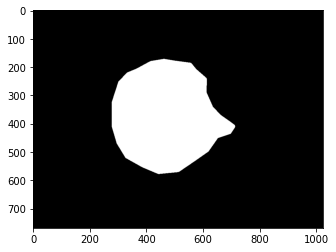

In [256]:
annotation_image_path = '29/ISIC_0010014_Segmentation.png'
a_image = cv2.imread(annotation_image_path)
print(a_image.shape)
print(type(a_image[0][0][0]))
plt.imshow(cv2.cvtColor(a_image, cv2.COLOR_BGR2RGB))

In [227]:
labels

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [244]:
def convert_bw_image_to_wb(image):
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for k in range(image.shape[2]):
                if image[i][j][k]==0:
                    image[i][j][k]=255
                else:
                    image[i][j][k]=0
    image = image.astype(np.uint8)
    return image

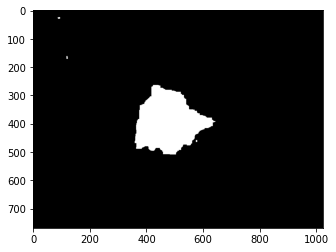

In [245]:
plt.imshow(convert_bw_image_to_wb(labels.copy()))

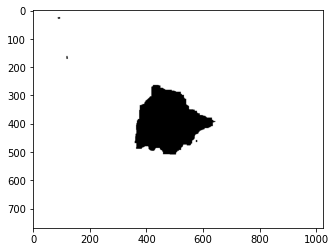

In [246]:
plt.imshow(labels)

In [247]:
pred_image = convert_bw_image_to_wb(labels.copy())

In [248]:
np.unique(a_image)

array([  0, 255], dtype=uint8)

In [249]:
np.unique(pred_image)

array([  0, 255], dtype=uint8)

In [251]:
cv2.cvtColor(a_image, cv2.COLOR_RGB2GRAY).shape

(768, 1024)

In [252]:
a_image==255

array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False,

In [274]:
def accuracy(pred_image, truth_image):
    
    pred_image = cv2.cvtColor(pred_image, cv2.COLOR_RGB2GRAY)
    truth_image = cv2.cvtColor(truth_image, cv2.COLOR_RGB2GRAY)
    
    correctly_predicted_count = 0
    true_segment_count = 0
    
    for i in range(pred_image.shape[0]):
        for j in range(pred_image.shape[1]):
            if pred_image[i][j] == truth_image[i][j]:
                correctly_predicted_count += 1
            
    true_segment_count = truth_image.shape[0]*truth_image.shape[1]
                
    accuracy = correctly_predicted_count/true_segment_count
    return accuracy

In [275]:
accuracy(pred_image, a_image)

0.8970069885253906

In [260]:
# Dice Coeffecient
def dice(im1, im2):

    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

In [261]:
dice(pred_image, a_image)

0.5076679005817029

In [270]:
def jacard_index(pred_image, truth_image):
    
    pred_image = cv2.cvtColor(pred_image, cv2.COLOR_RGB2GRAY)
    truth_image = cv2.cvtColor(truth_image, cv2.COLOR_RGB2GRAY)
    
    intersection_count = 0
    union_count = 0
    
    for i in range(pred_image.shape[0]):
        for j in range(pred_image.shape[1]):
            if pred_image[i][j]==255 and truth_image[i][j]==255:
                intersection_count += 1
                union_count += 1
            elif truth_image[i][j]==255:
                union_count += 1
            elif pred_image[i][j]==255:
                union_count += 1
                
    return intersection_count/union_count

In [271]:
jacard_index(pred_image, a_image)

0.3401842664776754

In [279]:
def sensitivity(pred_image, truth_image):
     
    pred_image = cv2.cvtColor(pred_image, cv2.COLOR_RGB2GRAY)
    truth_image = cv2.cvtColor(truth_image, cv2.COLOR_RGB2GRAY)
    
    correct_positive_count = 0
    true_positive_count = 0
    
    for i in range(pred_image.shape[0]):
        for j in range(pred_image.shape[1]):
            if pred_image[i][j]==255 and truth_image[i][j]==255:
                correct_positive_count += 1
                true_positive_count += 1
            elif truth_image[i][j]==255:
                true_positive_count += 1
                
    sensitivity = correct_positive_count/true_positive_count
    return sensitivity

In [280]:
sensitivity(pred_image, a_image)

0.34043385751669153

In [281]:
def specificity(pred_image, truth_image):
     
    pred_image = cv2.cvtColor(pred_image, cv2.COLOR_RGB2GRAY)
    truth_image = cv2.cvtColor(truth_image, cv2.COLOR_RGB2GRAY)
    
    true_negative_count = 0
    real_negative_count = 0
    
    for i in range(pred_image.shape[0]):
        for j in range(pred_image.shape[1]):
            if pred_image[i][j]==0 and truth_image[i][j]==0:
                true_negative_count  += 1
                real_negative_count += 1
            elif truth_image[i][j]==0:
                real_negative_count += 1
                
    specificity = true_negative_count/real_negative_count
    return specificity

In [282]:
specificity(pred_image, a_image)

0.9998644098438454

In [301]:
from sklearn.metrics import jaccard_score as jss

def jacard_index(pred_image, truth_image):
    
    pred_image = cv2.cvtColor(pred_image, cv2.COLOR_RGB2GRAY)
    truth_image = cv2.cvtColor(truth_image, cv2.COLOR_RGB2GRAY)
    
    return jss(list(truth_image.flatten()), list(pred_image.flatten()), average=None)

In [309]:
jacard_index(pred_image, a_image)[0]

0.8912313072063942

In [300]:
pred_image.flatten()

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [307]:
image_path[:12]+'.png'

'29/ISIC_0010014.png'

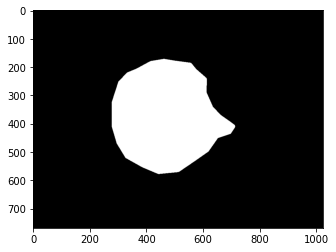

In [308]:
plt.imshow(a_image)

In [310]:
import pandas as pd

In [311]:
a=[1,2,3]
b=[4,5,6]

In [ ]:
pd.DataFrame